In [1]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
from glob import glob
from pyresample.bilinear import NumpyBilinearResampler
from pyresample import geometry
from matplotlib.colors import LogNorm
from oceanmodes import baroclinic
from fastjmd95 import jmd95numba

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4')
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')

In [3]:
Temp = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/temp.zarr')
Salt = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/salt.zarr')

In [4]:
Density = jmd95numba.rho(Salt.Salt, Temp.Theta, 0)
Density = Density.assign_coords(depth=('k', RC))
N2 = -9.81 *Density.mean('time').isel(i=slice(900,1100),j=slice(900,1100)).mean(['i','j']).diff('k')/Density.depth.diff('k')/1025
fm = 2*2*np.pi/24/3600*np.sin(-43*np.pi/180)

In [5]:
phi, RdS, vdS = baroclinic.neutral_modes_from_N2_profile(-RF[11:61], N2[10:60], fm,num_eigen=11,init_vector=None,num_Lanczos=None,iteration=None,tolerance=0)

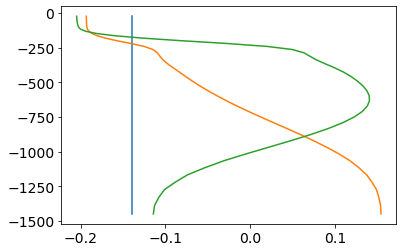

In [6]:
plt.plot(vdS[1:,0:3],RF[11:61])

In [7]:
vels_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_vels.zarr')
vels_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_vels.zarr')
eta_filtered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/filtered_eta_nom.zarr')
eta_unfiltered = xr.open_zarr('/swot/SUM03/spencer/hourly_filt/unfiltered_eta_nom.zarr')

uvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel_centered.zarr').sel(k=0)
vvel_eul = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel_centered.zarr').sel(k=0)
steric2 = xr.open_zarr('/swot/SUM02/spencer/steric_inc_mean.zarr')
steric_mean = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/steric_mean.zarr')

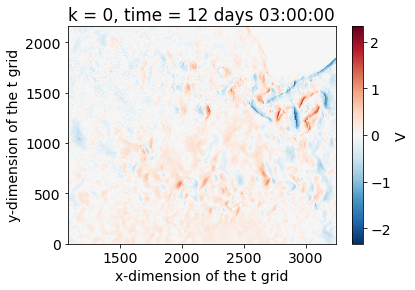

In [8]:
vvel_eul.isel(time=220).V.plot()

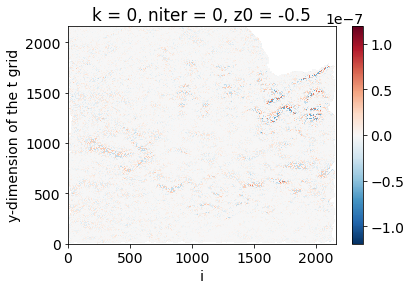

In [9]:
(uvel_eul.isel(time=43).U-vels_unfiltered.isel(time=1).u).plot()

In [10]:
#uvel_eul.isel(time=slice(1,250)).time
vels_filtered['time']=uvel_eul.isel(time=slice(42,42+170)).time
vels_unfiltered['time']=uvel_eul.isel(time=slice(42,42+170)).time
eta_filtered['time']=uvel_eul.isel(time=slice(42,42+170)).time

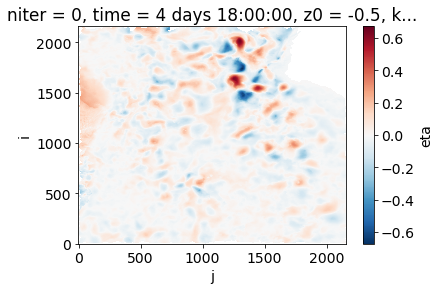

In [11]:
eta_filtered.isel(time=1).eta.plot()

In [12]:
ssh_unfilt = (steric2-steric_mean).isel(time=slice(0,254))
ssh_unfilt['time']=uvel_eul.isel(time=slice(0,170+42*2)).time

In [13]:
rossby_radius = xr.DataArray(RdS,dims=['Mode'])
rossby_radius

<xarray.DataArray (Mode: 11)>
array([3.18826406e+09, 1.11589611e+04, 6.10257796e+03, 3.94067152e+03,
       2.76847388e+03, 2.13333784e+03, 1.75954966e+03, 1.54576930e+03,
       1.36815190e+03, 1.20269432e+03, 1.07375616e+03])
Dimensions without coordinates: Mode

In [27]:
merged_ds = uvel_eul.isel(time=slice(1,254)).rename({'U':'unfiltered_u'}).merge(
    vels_filtered.astype('float32').rename({'u':'lagfiltered_u','v':'lagfiltered_v'}))
merged_ds = merged_ds.merge(vvel_eul.isel(time=slice(1,254)).rename({'V':'unfiltered_v'}))
merged_ds = merged_ds.merge(eta_filtered.astype('float32').rename({'eta':'lagfiltered_ssh'}))
merged_ds = merged_ds.merge(ssh_unfilt.drop_vars('niter').rename({'steric': 'unfiltered_steric_ssh'}))
merged_ds = merged_ds.merge(rossby_radius.rename('Rossby_radius'))
merged_ds = merged_ds.assign_coords({'Mode':['bartotropic mode','1st baroclinic mode','2nd baroclinic mode',
                                 '3rd baroclinic mode','4th baroclinic mode', '5th baroclinic mode',
                                '6th baroclinic mode','7th baroclinic mode','8th baroclinic mode',
                                '9th baroclinic mode','10th baroclinic mode']})

/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/dask/array/core.py:4048: PerformanceWarning: Increasing number of chunks by factor of 12
  **blockwise_kwargs,
/home/spencerj/.conda/envs/pangeo2/lib/python3.7/site-packages/xarray/core/indexing.py:1381: PerformanceWarning: Slicing is producing a large chunk. To 

In [28]:
merged_ds.x0.attrs['units']='degrees_east'
merged_ds.x0.attrs['long_name']='longitude'
merged_ds.y0.attrs['units']='degrees_north'
merged_ds.y0.attrs['long_name']='latitude'
merged_ds.z0.attrs['units']='meters'
merged_ds.z0.attrs['long_name']='depth'
merged_ds=merged_ds.drop_vars(['x','y','face','niter'])

merged_ds.Rossby_radius.attrs['long_name']='Rossby radius of deformation'
merged_ds.Rossby_radius.attrs['units']='meters'
merged_ds.Mode.attrs['long_name']='Mode for the associated rossby radius of deformation, obtained from solving eigenvalue problem for regional mean density profile'
merged_ds.time.attrs['units_comment']= 'ns since 2011-09-10'

merged_ds.unfiltered_u.attrs['units'] = 'm/s'
merged_ds.unfiltered_v.attrs['units'] = 'm/s'
merged_ds.lagfiltered_u.attrs['units'] = 'm/s'
merged_ds.lagfiltered_v.attrs['units'] = 'm/s'
merged_ds.lagfiltered_ssh.attrs['units'] = 'meters'
merged_ds.unfiltered_steric_ssh.attrs['units'] = 'meters'

merged_ds.unfiltered_u.attrs['long_name'] = 'Unfiltered zonal velocity on tracer points'
merged_ds.unfiltered_v.attrs['long_name'] = 'Unfiltered meridional velocity on tracer points'
merged_ds.lagfiltered_u.attrs['long_name'] = 'Lagrangian filtered zonal velocity on tracer points'
merged_ds.lagfiltered_v.attrs['long_name'] = 'Lagrangian filtered meridional velocity on tracer points'
merged_ds.lagfiltered_ssh.attrs['long_name'] = 'Lagrangian filtered steric sea surface height anomaly'
merged_ds.unfiltered_steric_ssh.attrs['long_name'] = 'Steric sea surface height anomaly'

from datetime import date
today = date.today()

merged_ds.attrs['title'] = '2 weeks of hourly surface velocity and ssh, both filtered and unfiltered'
merged_ds.attrs['institution'] = 'LDEO'
merged_ds.attrs['source'] = 'MITgcm LLC4320, with filtering methods applied to some of the data'
merged_ds.attrs['history'] = 'This version created ' + str(today) + ' by C. Spencer Jones'
merged_ds.attrs['references'] = 'Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. Separating balanced and unbalanced flow at the surface of the Agulhas region using Lagrangian filtering (in prep)'


In [25]:
merged_ds

<xarray.Dataset>
Dimensions:                (Mode: 11, i: 2160, j: 2160, time: 254)
Coordinates:
  * time                   (time) timedelta64[ns] NaT ... 13 days 12:00:00
  * i                      (i) int64 1080 1081 1082 1083 ... 3236 3237 3238 3239
  * j                      (j) float64 0.0 1.0 2.0 ... 2.158e+03 2.159e+03
    k                      int64 0
    x0                     (i) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    y0                     (j) float64 dask.array<chunksize=(2160,), meta=np.ndarray>
    z0                     float64 -0.5
  * Mode                   (Mode) <U20 'bartotropic mode' ... '10th baroclini...
Data variables:
    unfiltered_u           (time, j, i) float32 dask.array<chunksize=(2, 180, 180), meta=np.ndarray>
    lagfiltered_u          (time, i, j) float32 dask.array<chunksize=(43, 180, 180), meta=np.ndarray>
    lagfiltered_v          (time, i, j) float32 dask.array<chunksize=(43, 180, 180), meta=np.ndarray>
    unfiltered_v           (time, j, i) float32 dask.array<chunksize=(2, 180, 180), meta=np.ndarray>
    lagfiltered_ssh        (time, i, j) float32 dask.array<chunksize=(43, 180, 180), meta=np.ndarray>
    unfiltered_steric_ssh  (time, j, i) float32 dask.array<chunksize=(2, 2160, 2160), meta=np.ndarray>
    Rossby_radius          (Mode) float64 3.188e+09 1.116e+04 ... 1.074e+03
Attributes:
    title:        2 weeks of hourly surface velocity and ssh, both filtered a...
    institution:  LDEO
    source:       MITgcm LLC4320, with filtering methods applied to some of t...
    history:      This version created 2022-04-20 by C. Spencer Jones
    references:   Jones, C. S., Xiao, Q. , Abernathey, R. P. , Smith, K. S. S...

In [30]:
merged_ds.chunk({"time": 1, "i": 180,"j":180}).to_zarr('/swot/SUM02/spencer/daily_filt/two_weeks.zarr')#.lagfiltered_v.isel(time=200).plot()

In [ ]:
merged_ds.unfiltered_v.isel(time=220).plot()